In [ ]:
# 06c - Interprétation du modèle Yolo v8
# Analyse des résultats du modèle entraîné

In [2]:
# Définitions globales
HOME = '/Users/u600141/OneDrive - La Francaise des Jeux/Data/constructions/'
PATHS_BDTOPO_PICKLE = HOME + 'images/BDTOPO/pickle/'
PATHS_BDORTHO_PICKLE = HOME + 'images/BDORTHO_RGB/pickle/'

PATHS_YOLO = HOME + 'images/yolo/'
PATHS_MODELS = PATHS_YOLO + 'models/'
PATHS_IMG_TRAIN = PATHS_YOLO + 'RGB/images/train/'
PATHS_IMG_VALID = PATHS_YOLO + 'RGB/images/val/'
PATHS_IMG_TEST = PATHS_YOLO + 'RGB/images/test/'
PATHS_LBL_TRAIN = PATHS_YOLO + 'RGB/labels/train/'
PATHS_LBL_VALID = PATHS_YOLO + 'RGB/labels/val/'
PATHS_LBL_TEST = PATHS_YOLO + 'RGB/labels/test/'

SEED = 123


In [3]:
# Imports
import pandas as pd
import geopandas as gpd
import shapely as sh
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import torch


In [4]:
# Chargement des méta-données BDTOPO
dft = pd.read_pickle(PATHS_BDTOPO_PICKLE + 'dft.pkl')
print (f'dft chargé, taille : {len(dft)}')

# Chargement des méta-données BDORTHO
dfi = pd.read_pickle(PATHS_BDORTHO_PICKLE + 'dfi.pkl')
print (f'dfi chargé, taille : {len(dfi)}')

dft chargé, taille : 694950
dfi chargé, taille : 11875


In [11]:
# Chargement du modèle et transfert des poids
# Ici, il s'agit du modèle issu de l'entraînement, que Yolo a dû sauvegarder dans un sous-répertoire models (voir doc)

model = YOLO(PATHS_MODELS + 'yolov8m-seg-GPUT100-11h.pt')



0: 320x320 25 buildings, 79.8ms
Speed: 6.1ms preprocess, 79.8ms inference, 14.2ms postprocess per image at shape (1, 3, 320, 320)


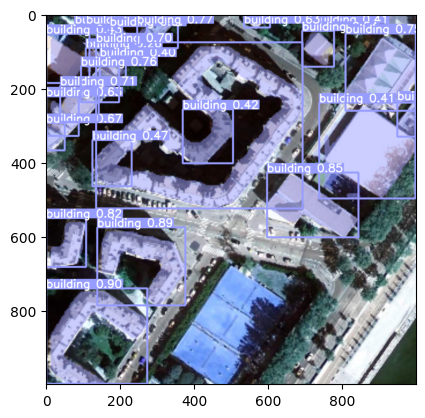

In [12]:
# Prédiction et affichage d'une image par le modèle
imgs = [PATHS_IMG_VALID + '00-004.jpg']
results = model(imgs)
# Process results list
for result in results:
    x = result.plot()  # display to screen
    result.save_txt(PATHS_YOLO + 'toto.txt')
    plt.imshow(x)
    plt.show();
    #result.save(filename='result.jpg')  # save to disk


(1, 122, 2)


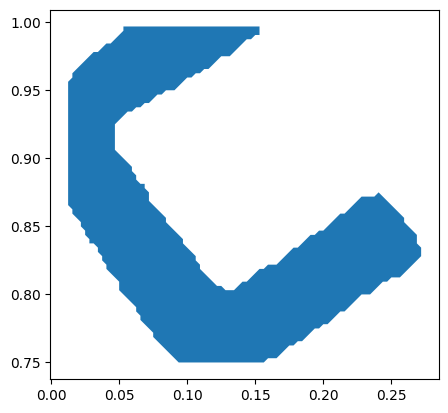

In [13]:
# Test de récupération de polygone prédit
print (np.array(result.masks[0].xyn).shape)
points = np.array(result.masks[0].xyn).reshape((122, 2))
poly = gpd.GeoSeries(sh.geometry.Polygon([[p[0], p[1]] for p in points]))
poly.plot()
plt.show();

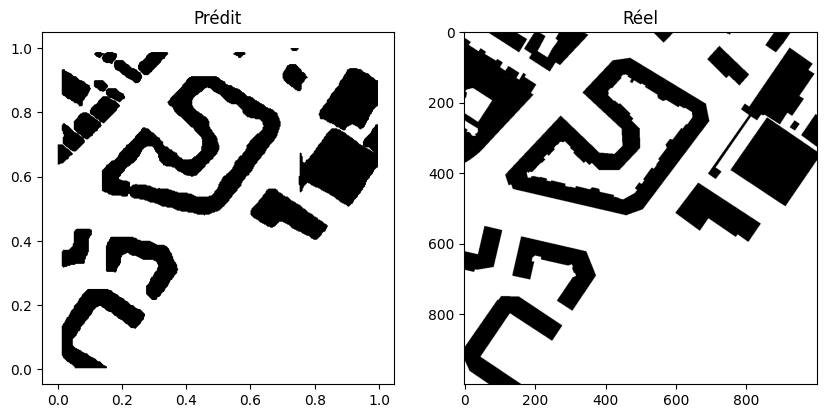

In [14]:
# Affichage du masque prédit et du masque réel

fig = plt.figure(figsize=(10, 10))
# Masque prédit
ax = fig.add_subplot(121)
for r in result.masks:
    points = np.array(r.xyn).squeeze()
    if (len(points) > 2): # sinon ce n'est pas un polygone
        points = [[x, 1-y] for [x, y] in points]
        pred_polygons = gpd.GeoSeries(sh.geometry.Polygon([[p[0], p[1]] for p in points]))
        pred_polygons.plot(ax=ax, cmap='gray')
plt.title('Prédit')

# Masque réel
ax = fig.add_subplot(122)
imglabel = cv2.imread(
    '/Users/u600141/Library/CloudStorage/OneDrive-LaFrancaisedesJeux/Data/constructions/images/BDORTHO_RGB/masks_1000x1000/mask-00-004.png', cv2.IMREAD_GRAYSCALE)
ax.imshow(255-imglabel, cmap='gray') # ATTENTION : on inverse le masque réel en Y
plt.title('Réel')

plt.show();

In [15]:
# notmalizePolygons() permet de mettre les coordonnées des polygones au format Yolo, à savoir :
#   - normalisées entre 0 et 1
#   - origine en haut à gauche (d'où reverseY)
#   - abs() est utilisée pour supprimer les erreurs d'arrondi négatif vers 0
def normalizePolygon(xy, xrange, yrange, reverseY=False):
    if (reverseY==True):
        ret = abs((xy - [xrange[0], yrange[1]]) * [1/(xrange[1]-xrange[0]), 1/(yrange[0]-yrange[1])])
    else:
        ret = abs((xy - [xrange[0], yrange[0]]) * [1/(xrange[1]-xrange[0]), 1/(yrange[1]-yrange[0])])
    return ret

# getIntersectingPolygons() : retourne l'intersection entre les polygones du dataframe et les bords de l'image
def getIntersectingPolygons(df, xrange, yrange, minArea=0, normalize=False, reverseY=False):
    rect_poly = sh.Polygon([(xrange[0], yrange[0]),
                            (xrange[1], yrange[0]),
                            (xrange[1], yrange[1]),
                            (xrange[0], yrange[1])])
    intersect = df['geometry'].values.intersection(rect_poly)
    intersect = intersect[~ intersect.is_empty]
    if (normalize==True):
        intersect = gpd.GeoSeries(sh.transform(intersect, lambda p : normalizePolygon(p, xrange, yrange, reverseY)))
    if (minArea > 0):
        intersect = intersect[intersect.area >= minArea]
    return intersect


In [ ]:
img_metadata = dfi[(dfi['imgID']==0) & (dfi['cutID']==4)]

xrange, yrange = img_metadata['xrange'].values[0], img_metadata['yrange'].values[0]
true_polygons = getIntersectingPolygons(dft, xrange, yrange, normalize=True, reverseY=True)
fig, ax = plt.subplots(1)
true_polygons.plot(ax=ax)
gpd.GeoSeries(pred_polygons[1]).plot(ax=ax, color='red')
plt.show();

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/plotting.py:409: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


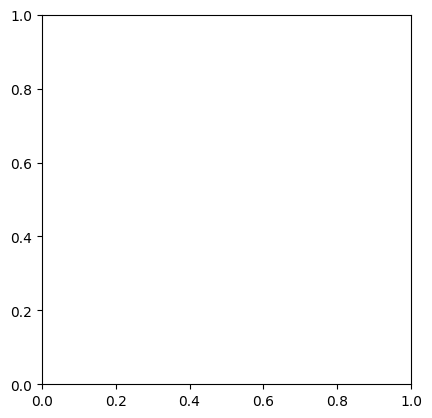

In [70]:
# À faire : Algo de calcul des immeubles illégaux

for poly in pred_polygons:
    intersect = poly.intersection(true_polygons)
    intersect = intersect[~ intersect.is_empty]
intersect.plot()
plt.show();

0    POLYGON ((0.11563 0.90000, 0.11250 0.89688, 0....
dtype: geometry


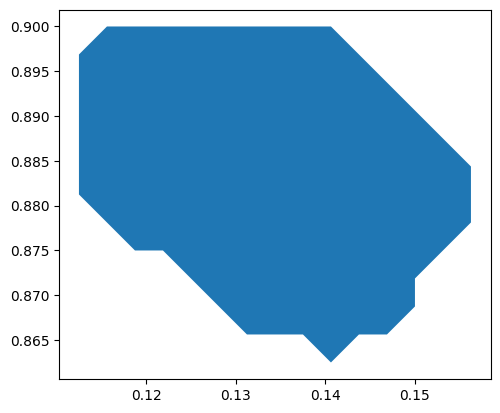

In [58]:
print (pred_polygons)
pred_polygons.plot()
plt.show();

In [37]:
print (len(np.array(result.masks[22].xyn).squeeze()))

2
